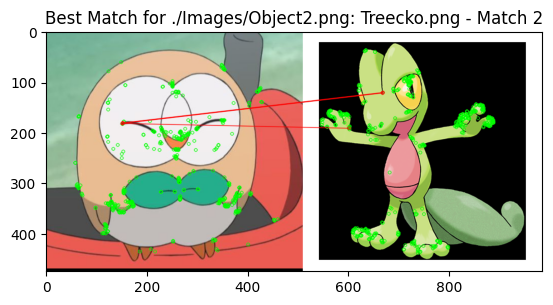

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def pre_v1(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq_img = cv2.equalizeHist(gray_img)
    blur_img = cv2.medianBlur(eq_img, 5)

    return blur_img

def pre_v2(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq_img = cv2.equalizeHist(gray_img)
    blur_img = cv2.GaussianBlur(eq_img, (3, 3), 0)
    
    return blur_img

def find_best_match(pre_func, target_path, data_path):
    target_img = cv2.imread(target_path)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    target_gray = pre_func(target_img)

    akaze = cv2.ORB.create()
    target_keypoints, target_desc = akaze.detectAndCompute(target_gray, None)

    target_desc = np.float32(target_desc)

    index_param = dict(algorithm=1, tree=5)
    search_param = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_param, search_param)

    # flann = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    best_match = 0
    best_match_data = {}

    for img_path in os.listdir(data_path):
        img = cv2.imread(data_path + img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = pre_func(img)

        img_keypoints, img_desc = akaze.detectAndCompute(img_gray, None)
        img_desc = np.float32(img_desc)

        matches = flann.knnMatch(target_desc, img_desc, 2)
        matches_mask = [[0, 0] for _ in range(len(matches))]

        curr_match = 0

        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                curr_match += 1
                matches_mask[i] = [1, 1]
        
        if curr_match > best_match:
            best_match = curr_match
            best_match_data = {
                "image": img,
                "name": img_path,
                "keypoints": img_keypoints,
                "descriptor": img_desc,
                "match": matches,
                "matches_mask": matches_mask,
                "best_match": best_match
            }
    
    img_result = cv2.drawMatchesKnn(
        target_img, target_keypoints,
        best_match_data["image"], best_match_data["keypoints"],
        matches, None,
        matchColor=[255, 0, 0],
        singlePointColor=[0, 255, 0],
        matchesMask=best_match_data["matches_mask"]
    )

    plt.figure()
    plt.imshow(img_result)
    plt.title(f"Best Match for {target_path}: {best_match_data["name"]} - Match {best_match_data['best_match']}")
    plt.show()

find_best_match(pre_v2, "./Images/Object2.png", "./Images/Data/")